# CNN Classifier using ResNet34

In [1]:
# Jupyter related code
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Importing libraries
from fastai.vision import *
from fastai.metrics import error_rate
from fastai.callbacks.mem import PeakMemMetric

# Variable definition
bs = 64
master_path = Path('../data')
training_dataset_path = master_path/'training-dataset'

metrics = [error_rate, accuracy]

epoch,train_loss,valid_loss,error_rate,accuracy,cpu used,peak,gpu used,peak,time
0,0.117436,0.043176,0.014341,0.985659,0,1,244,3240,02:11
1,0.044582,0.049416,0.013278,0.986722,0,1,-1,2296,02:10
2,0.019854,0.007055,0.002125,0.997875,0,1,0,2296,02:10
3,0.017433,0.005931,0.001593,0.998407,0,1,-19,2354,02:11


PosixPath('../data/training-dataset/models/resnet-34-no_tunning.pth')

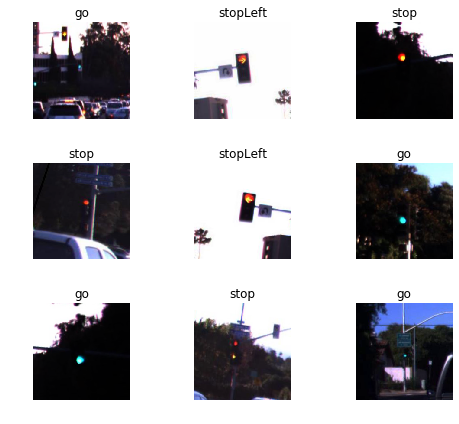

In [1]:
# Creating data for learner
data = ImageDataBunch.from_folder(training_dataset_path
                                  , ds_tfms = get_transforms()
                                  , size = 224
                                  , bs = bs
                                 ).normalize(imagenet_stats)

data.show_batch(rows = 3, figsize = (7, 6))

learn = cnn_learner(data
                    , models.resnet34
                    , metrics = metrics
                    , callback_fns = PeakMemMetric
                   )

learn.fit_one_cycle(4)
learn.save('resnet-34-no_tunning', True)

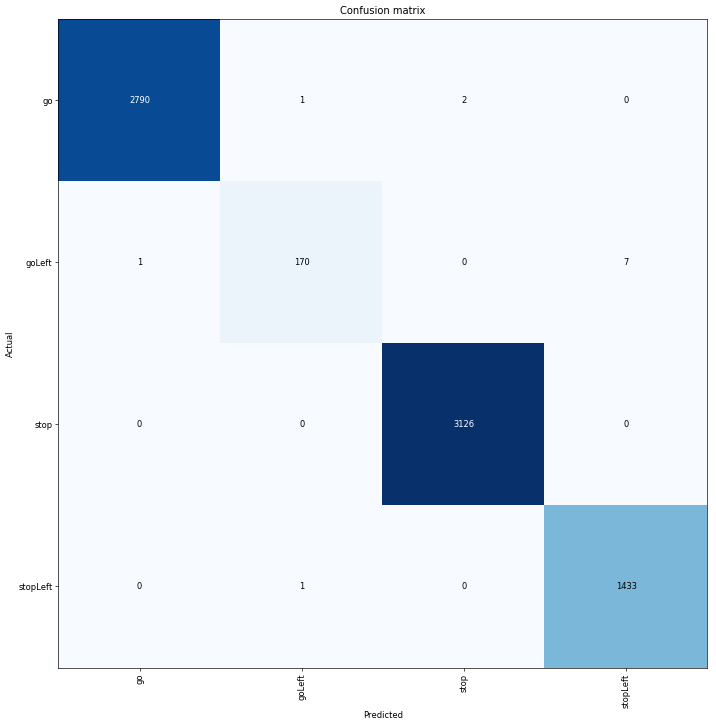

In [2]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()
len(data.valid_ds) == len(losses) == len(idxs)
interp.plot_confusion_matrix(figsize = (12, 12), dpi = 60)

[('goLeft', 'stopLeft', 7), ('go', 'stop', 2)]

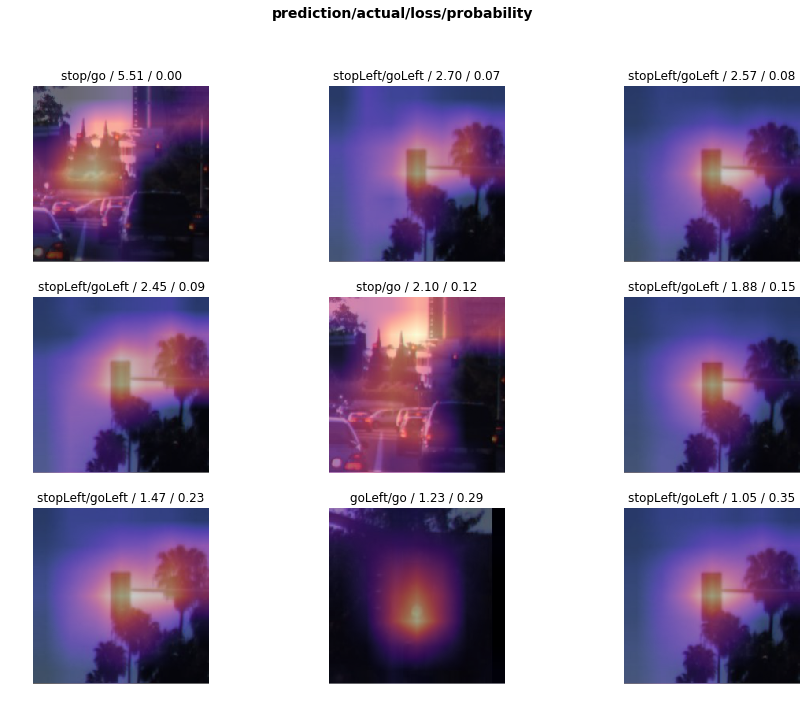

In [3]:
interp.plot_top_losses(9, figsize = (15, 11))
interp.most_confused(min_val = 2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


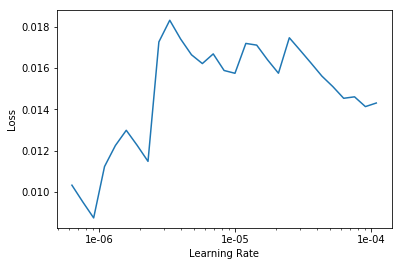

In [4]:
learn.unfreeze()
learn.load('resnet-34-no_tunning')
learn.lr_find()
learn.recorder.plot()

In [5]:
learn.unfreeze()

epochs = 4
min_range = 1e-5
max_range = 1e-4
max_lr = slice(min_range, max_range)
learn.fit_one_cycle(epochs, max_lr)
learn.save('resnet-34-tunned')

epoch,train_loss,valid_loss,error_rate,accuracy,cpu used,peak,gpu used,peak,time
0,0.011382,0.006646,0.002523,0.997477,0,1,238,1620,02:56
1,0.007880,0.002832,0.001062,0.998938,0,1,-22,1794,02:58
2,0.004263,0.001295,0.000398,0.999602,0,1,72,1810,03:00
3,0.001841,0.002040,0.000664,0.999336,0,1,-6,1801,02:58


# CNN Classifier using ResNet50

In [2]:
bs_50 = 32
data_50 = ImageDataBunch.from_folder(training_dataset_path
                                  , ds_tfms = get_transforms()
                                  , size = 224
                                  , bs = bs_50
                                 ).normalize(imagenet_stats)
learn_50 = cnn_learner(data_50
                       , models.resnet50
                       , metrics = metrics
                       , callback_fns = PeakMemMetric
                      )
learn_50.fit_one_cycle(4)
learn_50.save('resnet-50-no_tunning', True)

epoch,train_loss,valid_loss,error_rate,accuracy,cpu used,peak,gpu used,peak,time
0,0.083569,0.050015,0.013278,0.986722,0,1,148,4450,04:46
1,0.036135,0.012032,0.004116,0.995884,0,1,-28,3017,04:42
2,0.012469,0.003186,0.000929,0.999071,0,1,14,3012,04:42
3,0.007098,0.004313,0.000929,0.999071,0,1,108,3065,04:43


PosixPath('../data/training-dataset/models/resnet-50-no_tunning.pth')

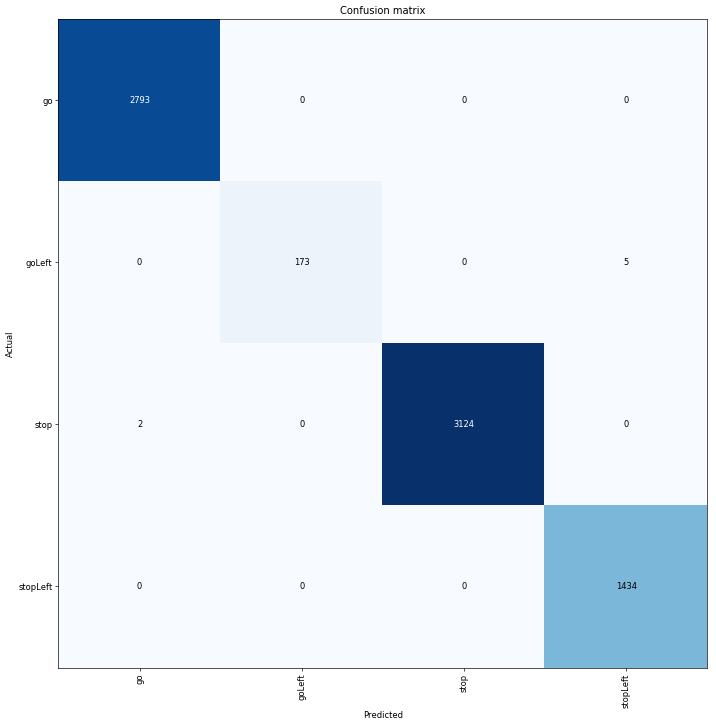

In [3]:
interp_50 = ClassificationInterpretation.from_learner(learn_50)
interp_50.plot_confusion_matrix(figsize = (12, 12), dpi = 60)

[('goLeft', 'stopLeft', 5), ('stop', 'go', 2)]

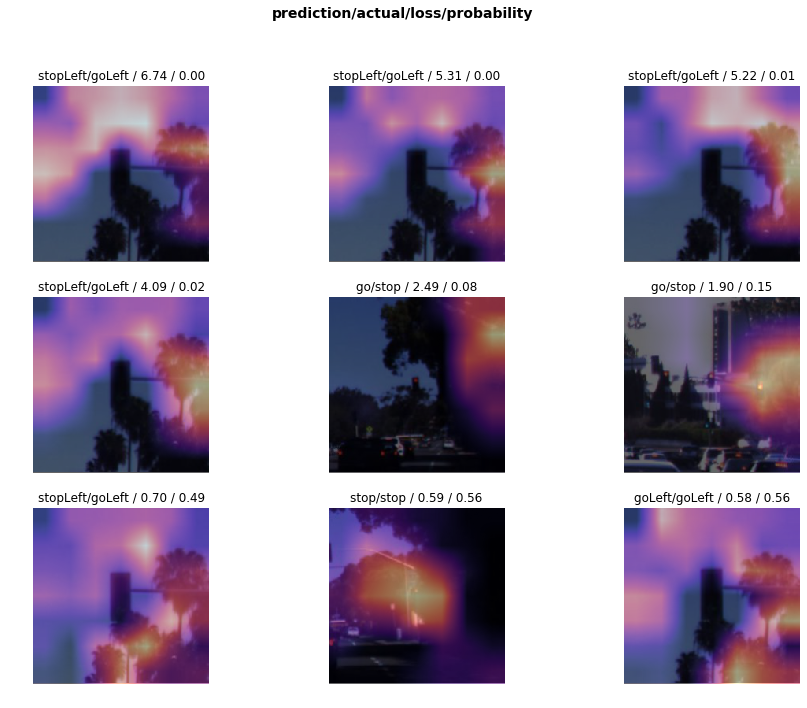

In [4]:
interp_50.plot_top_losses(9, figsize = (15, 11))
interp_50.most_confused(min_val = 2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


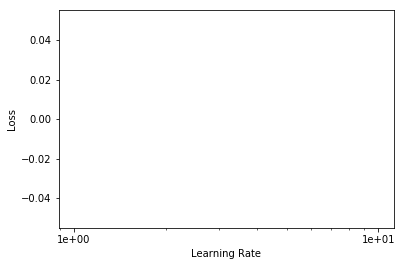

In [11]:
learn_50.unfreeze()
learn_50.load('resnet-50-no_tunning')
learn_50.lr_find()
learn_50.recorder.plot()

In [23]:
learn_50.unfreeze()

epochs = 10
min_range = 1e-5
max_range = 1e-3
max_lr = slice(min_range, max_range)
learn_50.fit_one_cycle(epochs, max_lr)
learn_50.save('resnet-50-tunned')

epoch,train_loss,valid_loss,error_rate,time
0,0.313704,1.014833,0.347826,00:02
1,0.257785,0.907100,0.321739,00:02
2,0.212983,0.688523,0.278261,00:02
3,0.222788,0.581618,0.217391,00:02
4,0.194272,0.585218,0.200000,00:02
5,0.177995,0.564532,0.165217,00:02
6,0.157871,0.469555,0.173913,00:02
7,0.133255,0.478184,0.182609,00:02
8,0.134912,0.474717,0.182609,00:02
9,0.124876,0.498285,0.182609,00:02


# CNN Classifier using DenseNet121

In [13]:
bs_dn = 32

data_dn = ImageDataBunch.from_folder(training_dataset_path
                                  , ds_tfms = get_transforms()
                                  , size = 224
                                  , bs = bs_dn
                                 ).normalize(imagenet_stats)
learn_dn = cnn_learner(data_dn
                       , models.densenet121
                       , metrics = metrics
                       , callback_fns = PeakMemMetric
                      )
learn_dn.fit_one_cycle(4)
learn_dn.save('densenet-121-no_tunning', True)

epoch,train_loss,valid_loss,error_rate,accuracy,cpu used,peak,gpu used,peak,time
0,0.078055,0.019554,0.005311,0.994689,13,21,37,4230,05:12
1,0.016235,0.006848,0.001992,0.998008,0,1,0,4152,05:11
2,0.009594,0.002795,0.001195,0.998805,0,1,0,4152,05:11
3,0.004835,0.001244,0.000664,0.999336,0,1,19,4133,05:11


PosixPath('../data/training-dataset/models/densenet-121-no_tunning.pth')

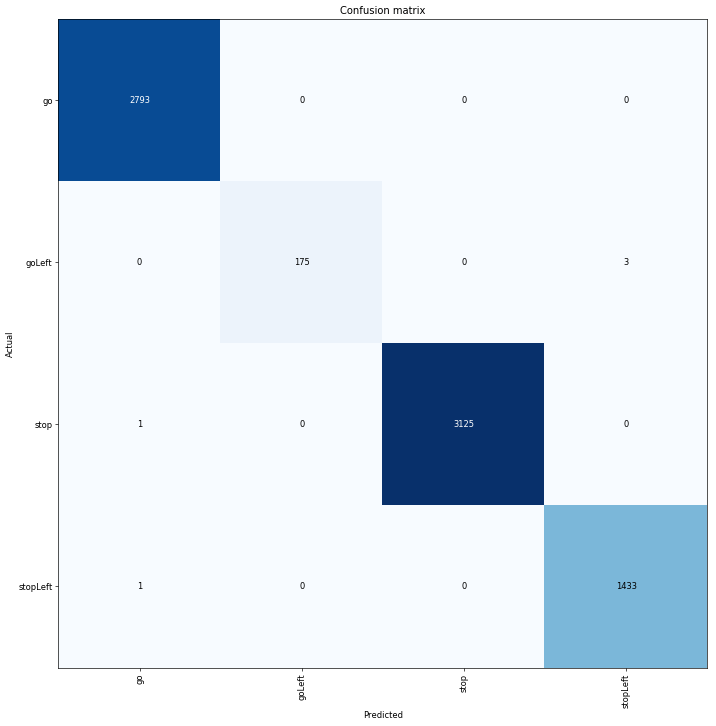

In [14]:
interp_dn = ClassificationInterpretation.from_learner(learn_dn)
interp_dn.plot_confusion_matrix(figsize = (12, 12), dpi = 60)

[('goLeft', 'stopLeft', 3), ('stop', 'go', 1), ('stopLeft', 'go', 1)]

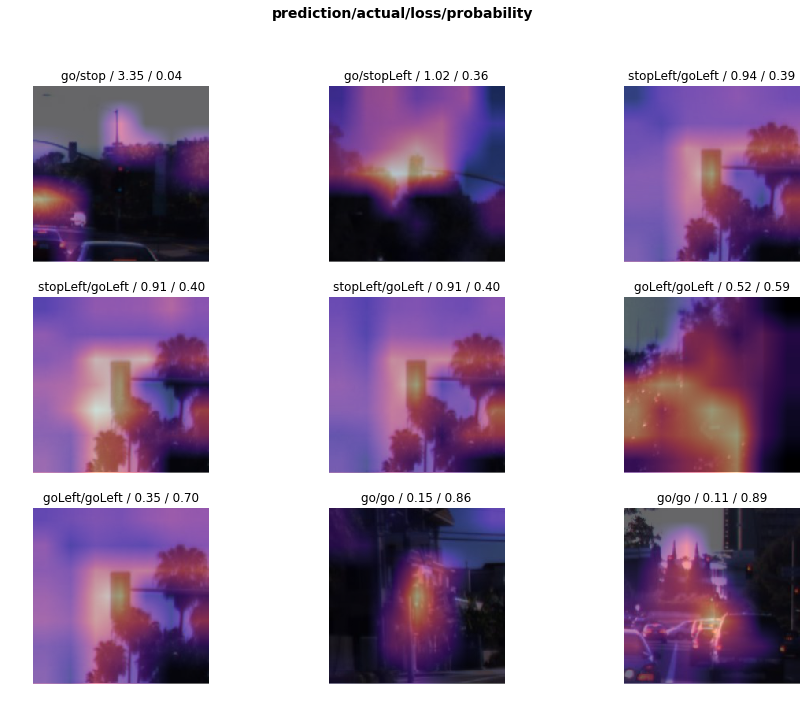

In [15]:
interp_dn.plot_top_losses(9, figsize = (15, 11))
interp_dn.most_confused(min_val = 1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


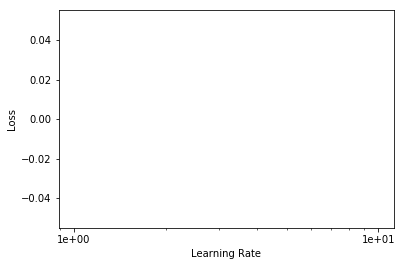

In [16]:
learn_dn.unfreeze()
learn_dn.load('densenet-121-no_tunning')
learn_dn.lr_find()
learn_dn.recorder.plot()

In [5]:
learn_dn.unfreeze()

epochs = 10
min_range = 1e-6
max_range = 1e-3
max_lr = slice(min_range, max_range)
learn_dn.fit_one_cycle(epochs, max_lr)
learn_dn.save('densenet-121-tunned')

epoch,train_loss,valid_loss,error_rate,time
0,0.205717,0.573827,0.200000,00:02
1,0.189824,0.538354,0.191304,00:02
2,0.204643,0.523379,0.200000,00:02
3,0.189569,0.541261,0.182609,00:02
4,0.189189,0.579523,0.200000,00:02
5,0.183698,0.548072,0.165217,00:02
6,0.167095,0.536208,0.182609,00:02
7,0.167302,0.546122,0.200000,00:02
8,0.161434,0.537547,0.182609,00:02
9,0.161343,0.541668,0.200000,00:02
